<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/main/ArkhipovAS/%22Selector_CVAE_v3_RGB_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive  # For working with Google Drive
#rom google.colab import files  # For working with files
#-------------Удаленная среда--------------------------------------------------
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dropout, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Reshape, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import gc
from tensorflow.keras.losses import mse, binary_crossentropy
import shutil
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
import matplotlib.animation as animation
import imageio
from IPython.display import Image as DisplayImage
from IPython.display import display

from sklearn.neighbors import NearestNeighbors #Библиотека scikit-learn (sklearn) для поиска ближайших соседей, Этот класс предоставляет функциональность для поиска


## Первый запуск. Загрузка данных и обработка

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!rm -R '/content/selector/' # Проверяем наличие папки selector. Если есть, удаляем ее

rm: /content/selector/: No such file or directory


In [ ]:
cd /Users/sasha/plutus/content/selector

/Users/sasha/plutus/content/selector


In [ ]:
ls

In [ ]:
# Проверяем, существует ли папка
if not os.path.exists('/content/selector'):
    # Создаем папку
    os.makedirs('/content/selector')

OSError: ignored

In [ ]:
# Первый запуск. Обработка изображений
# Указываем путь к базе в Google Drive, создаем папку и извлекаем туда базу
# !unzip -q '/content/drive/MyDrive/ai/Base/dataset.zip' -d '/content/selector'

# Extract the dataset to the specified directory
#!unzip -q '/content/drive/MyDrive/ai/Base/dataset_conv.zip' -d '/content/selector/dataset'

# Extract the dataset to the specified directory
!unzip -q '/content/drive/MyDrive/ai/Base/dataset_conv_256_rgb.zip' -d '/Users/sasha/plutus/content/selector/dataset'

unzip:  cannot find or open /content/drive/MyDrive/ai/Base/dataset_conv_256_rgb.zip, /content/drive/MyDrive/ai/Base/dataset_conv_256_rgb.zip.zip or /content/drive/MyDrive/ai/Base/dataset_conv_256_rgb.zip.ZIP.


In [ ]:
!rm -R '/content/selector/dataset/dress  business'
!rm -R '/content/selector/dataset/t-shirt men'
!rm -R '/content/selector/dataset/sportswear men'
!rm -R '/content/selector/dataset/trousers men'
!rm -R '/content/selector/dataset/shirt men'
!rm -R '/content/selector/dataset/dress solemn'

In [ ]:
# Первый запуск. Архивация обработанного датасета и копирования на гуглдиск из временной директории колаба
# Путь к папке, которую нужно архивировать
source_folder = "/content/selector/dataset"

# Путь к папке, в которую нужно скопировать архив
destination_folder = "/content/drive/MyDrive/ai/Base/"

# Имя архива
archive_name = "dataset_conv_256_rgb.zip"

# Архивируем папку
shutil.make_archive("/content/selector/dataset_conv_256_rgb", "zip", source_folder)

# Копируем архив в другую папку
shutil.copy("/content/selector/dataset_conv_256_rgb.zip", f"{destination_folder}/{archive_name}")

'/content/drive/MyDrive/ai/Base//dataset_conv_256_rgb.zip'

In [ ]:
# Первый запуск. Обработка изображений
FILE_DIR = '/Users/sasha/plutus/content/selector/dataset'
#FILE_DIR = '/content/selector/dataset'

In [ ]:
# Первый запуск. Обработка изображений
# Изменяем размер изображения до 256х256
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Переменные для отслеживания текущей папки и количества обработанных изображений
current_folder = ""
processed_images = 0

# Проходим по папкам и файлам внутри каталога
for root, dirs, files in os.walk(FILE_DIR):
    for filename in files:
        # Полный путь к файлу
        file_path = os.path.join(root, filename)

        # Проверяем, является ли файл изображением
        if filename.endswith((".jpg", ".jpeg", ".png")):
            # Открываем изображение, изменяем его размер и преобразуем в оттенки серого
            img = Image.open(file_path)

            # Сохраняем измененное изображение обратно
            img.save(file_path)

            # Увеличиваем счетчик обработанных изображений в текущей папке
            processed_images += 1


    # Выводим сообщение после обработки каждой папки
    if current_folder != root:
        if current_folder:
            print(f"Папка {current_folder} обработана. Количество обработанных изображений: {processed_images}")
        current_folder = root
        processed_images = 0

# Выводим сообщение для последней обработанной папки
if current_folder:
    print(f"Папка {current_folder} обработана. Количество обработанных изображений: {processed_images}")

Папка /Users/sasha/plutus/content/selector/dataset обработана. Количество обработанных изображений: 2521
Папка /Users/sasha/plutus/content/selector/dataset/shirt men обработана. Количество обработанных изображений: 1064
Папка /Users/sasha/plutus/content/selector/dataset/t-shirt men обработана. Количество обработанных изображений: 831
Папка /Users/sasha/plutus/content/selector/dataset/sportswear men обработана. Количество обработанных изображений: 460
Папка /Users/sasha/plutus/content/selector/dataset/dress solemn обработана. Количество обработанных изображений: 1364
Папка /Users/sasha/plutus/content/selector/dataset/trousers men обработана. Количество обработанных изображений: 0


## Повторный запуск. Загрузка данных и обработка

In [ ]:
# Открываем изображение
img = Image.open("/Users/sasha/plutus/content/selector/dataset/shirt men/0 (2).jpg")
#img = Image.open("/dataset/shirt men/0 (2).jpg")

# Получаем размеры изображения
width, height = img.size

# Получаем количество каналов
channels = img.getbands()

# Выводим информацию об изображении
print(f"Ширина: {width}, Высота: {height}")
print(f"Количество каналов: {len(channels)}")

Ширина: 256, Высота: 256
Количество каналов: 3


In [ ]:
FILE_DIR = '/Users/sasha/plutus/content/selector/dataset'
#FILE_DIR = '/content/selector/dataset'

In [ ]:
# Initialize lists to store images and class labels
x_data = []
y_data = []
# Изменяем размер изображения до 256х256
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Traverse through folders and files within the directory
for root, dirs, files in os.walk(FILE_DIR):
    for filename in files:
        # Full path to the file
        file_path = os.path.join(root, filename)

        # Check if the file is an image
        if filename.endswith((".jpg", ".jpeg", ".png")):
            # Load the image
            if img.mode == 'RGBA':
              img = img.convert('RGB')
            img = Image.open(file_path).resize((IMG_HEIGHT, IMG_WIDTH)).convert("RGB")
            #img = Image.open(file_path).convert('L')  # Convert to grayscale
            #img = img.resize((100, 100))  # Resize to 100x100 pixels

            # Convert the image to a numpy array
            img_array = np.array(img)

            # Add the image to the x_data list
            x_data.append(img_array)

            # Get the class label from the parent folder name
            class_label = os.path.basename(root)

            # Add the class label to the y_data list
            y_data.append(class_label)

/opt/homebrew/Caskroom/miniforge/base/envs/test_p311_tfm050_mcs_290/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
length = len(x_data)
print(length)

6240


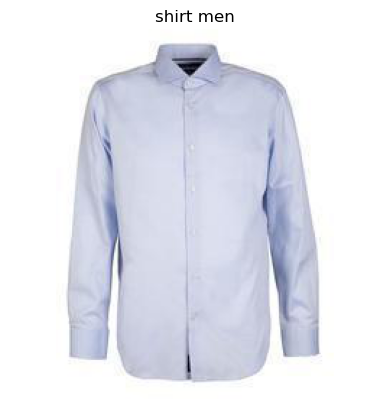

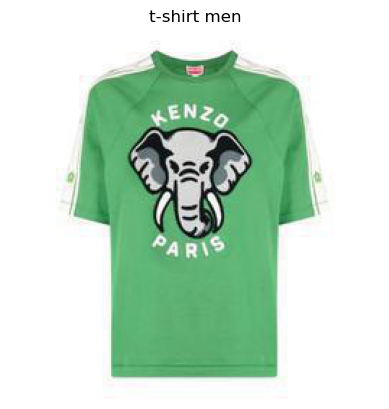

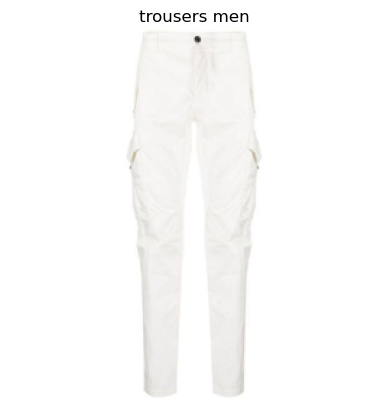

In [ ]:
def show_img(num):
  # Отображение Num элемента из x_data
  #plt.imshow(x_data[1135].reshape(100, 100), cmap='gray')
  plt.imshow(x_data[num])
  plt.title(y_data[num])
  plt.axis('off')
  plt.show()
show_img(1004)
show_img(3000)
show_img(6000)


In [ ]:
# Convert lists to numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

In [ ]:
# Normalize data
x_data = x_data.astype('float32') / 255.0

# Reshape data
x_data = x_data.reshape(-1, 256, 256, 3)


In [ ]:
x_data.shape

(6240, 256, 256, 3)

In [ ]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True, random_state=3)

In [ ]:
# Convert class labels to one-hot encoding format
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print(y_train_encoded[:])
y_train_onehot = to_categorical(y_train_encoded, 5)
print(y_train_onehot[:])

y_test_encoded = label_encoder.fit_transform(y_test)
y_test_onehot = to_categorical(y_test_encoded, 5)

[1 4 0 ... 3 1 4]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
y_train.shape

(4992,)

In [ ]:
x_train.shape

(4992, 256, 256, 3)

In [ ]:
# Задаем размерность входного изображения
input_shape = (256, 256, 3)
num_classes = 5
latent_dim = 10  # Размерность скрытого пространства

# Создаем энкодер
def create_encoder():
    input_img = Input(shape=input_shape, name='input_image')
    input_label = Input(shape=(num_classes,), name='input_label')

    x = Flatten()(input_img)
    # Объединяем входные данные изображения и метки классов
    x = tf.concat([x, input_label], axis=1)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Параметры средних и логарифма дисперсии в скрытом пространстве
    encoded = Dense(latent_dim, activation='relu')(x)

    # Создаем модели энкодера
    encoder = Model([input_img, input_label], encoded, name='encoder')
    return encoder

# Создаем декодер
def create_decoder():
    latent_inputs = Input(shape=(latent_dim,), name='latent_inputs')
    input_label_dec = Input(shape=(num_classes,), name='input_label_dec')

    # Объединяем сэмплированное латентное пространство и метки классов
    x = tf.concat([latent_inputs, input_label_dec], axis=-1)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoded = Reshape(input_shape)(x)

    # Create the decoder model
    decoder = Model([latent_inputs, input_label_dec], decoded, name='decoder')
    return decoder

#---------------
# Создаем CVAE
#---------------
def create_cvae(encoder, decoder):
    input_img = Input(shape=input_shape, name='input_image')
    input_label = Input(shape=(num_classes,), name='input_label')
    input_label_dec = Input(shape=(num_classes,), name='input_label_dec')


    # Получаем восстановленное изображение от декодера
    reconstructed_img = decoder([encoder([input_img, input_label]), input_label_dec])


    # Создаем модель CVAE
    cvae = Model([input_img, input_label, input_label_dec], reconstructed_img, name='cvae')

    return cvae

encoder = create_encoder()
decoder = create_decoder()
cvae = create_cvae(encoder, decoder)



In [ ]:
# Обучение энкодера
encoder.compile(optimizer='adam', loss='mse')
encoder.fit([x_train, y_train_onehot], x_train, epochs=10, batch_size=32)


Epoch 1/10


ValueError: ignored

In [ ]:
cvae.summary()

Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_label (InputLayer)       [(None, 5)]          0           []                               
                                                                                                  
 encoder (Functional)           (None, 10)           25177258    ['input_image[0][0]',            
                                                                  'input_label[0][0]']            
                                                                                               

In [ ]:
cvae.compile(optimizer='adam', loss='mse')

In [ ]:
# Обучение CVAE
history = cvae.fit([x_train, y_train_onehot, y_train_onehot], x_train, batch_size=128, epochs=30)

Epoch 1/30


2023-06-05 14:51:01.648325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 11s 244ms/step - loss: 0.0782
Epoch 2/30
39/39 [==============================] - 10s 251ms/step - loss: 0.0404
Epoch 3/30
39/39 [==============================] - 10s 248ms/step - loss: 0.0348
Epoch 4/30
39/39 [==============================] - 10s 253ms/step - loss: 0.0295
Epoch 5/30
39/39 [==============================] - 10s 249ms/step - loss: 0.0272
Epoch 6/30
39/39 [==============================] - 10s 248ms/step - loss: 0.0261
Epoch 7/30
39/39 [==============================] - 10s 248ms/step - loss: 0.0245
Epoch 8/30
39/39 [==============================] - 10s 246ms/step - loss: 0.0232
Epoch 9/30
39/39 [==============================] - 10s 256ms/step - loss: 0.0230
Epoch 10/30
39/39 [==============================] - 10s 257ms/step - loss: 0.0219
Epoch 11/30
39/39 [==============================] - 10s 252ms/step - loss: 0.0213
Epoch 12/30
39/39 [==============================] - 10s 252ms/step - loss: 0.0210
Epoch 13/30
39/39 [=====

In [ ]:
# Предсказание восстановленных изображений
reconstructed_images = cvae.predict([x_train, y_train_onehot, y_train_onehot])
n = 10  # Количество изображений для отображения

plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригинальное изображение
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_data[i].reshape(256, 256, 3), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Восстановленное изображение
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(256, 256, 3))
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

2023-06-05 15:04:23.608142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 13s 84ms/step


In [ ]:
cvae.save('/Users/sasha/plutus/content/selector/cvae_model_rgb_v1.1.h5')

In [ ]:
# Загрузка модели из файла
cvae = load_model('/Users/sasha/plutus/content/selector/cvae_model_rgb_v1.1.h5')

In [ ]:
# Предсказание восстановленных изображений
reconstructed_images = cvae.predict([x_test, y_test_onehot, y_test_onehot])


 1/39 [..............................] - ETA: 6s

2023-06-05 15:08:03.462158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 3s 83ms/step


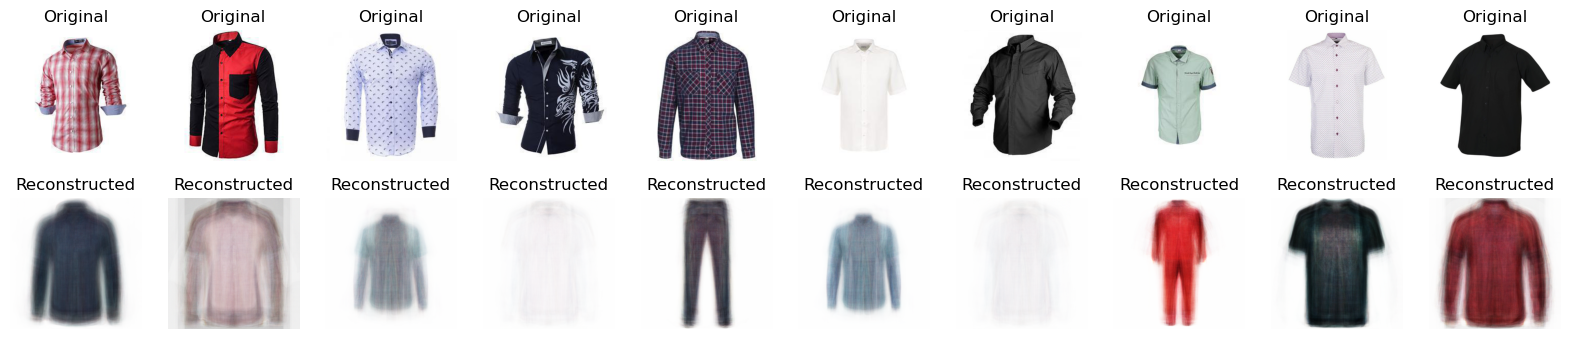

In [ ]:
n = 10  # Количество изображений для отображения

plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригинальное изображение
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_data[i].reshape(256, 256, 3), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Восстановленное изображение
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(256, 256, 3), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')
plt.show()

## Обучение с построением анимации изменения скрытого пространства

In [ ]:
def plot_scatter_animation(model, x_train, y_train, epochs):
    # Список для сохранения имен файлов с изображениями скаттер-плотов
    image_files = []

    # Обучение модели и создание скаттер-плотов после каждой эпохи
    for epoch in range(epochs):
        history = model.fit([x_train, y_train, y_train], x_train, batch_size=64, epochs=1)

        # Получение кодировщика из модели
        encoder = model.get_layer('encoder')

        # Получение скрытых представлений для обучающих данных
        latent_space = encoder.predict([x_train, y_train])[0]

        # Получение меток классов из y_train
        labels = np.argmax(y_train, axis=1)

        # Создание скаттер-плота с разделением точек по цветам классов
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)[0]
            plt.scatter(latent_space[indices, 0], latent_space[indices, 1], label='Class {}'.format(label))

        # Настройка осей, заголовка и легенды
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')
        plt.title('Scatter Plot - Epoch {}'.format(epoch+1))
        plt.legend()

        # Сохранение скаттер-плота в файл
        image_file = 'scatter_epoch{}.png'.format(epoch+1)
        plt.savefig(image_file)
        plt.close()

        # Добавление имени файла в список
        image_files.append(image_file)

    # Создание анимации GIF из сохраненных изображений
    images = []
    for image_file in image_files:
        image = Image.open(image_file)
        images.append(np.array(image))

    imageio.mimsave('scatter_animation.gif', images, duration=0.2)


In [ ]:
plot_scatter_animation(cvae, x_train, y_train_onehot, epochs=20)

156/156 [==============================] - 3s 21ms/step


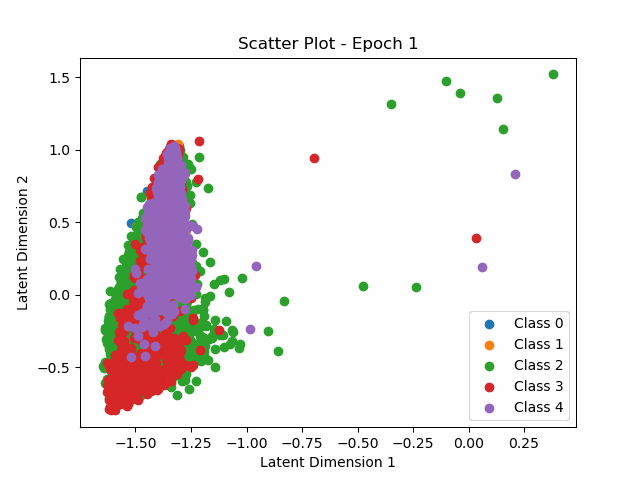

In [ ]:
# Отображение анимации
display(DisplayImage(filename="scatter_animation.gif"))

## Поиск ближайших соседей

In [ ]:
def find_nearest_neighbors(image, category, k=7):
    # Изменяем форму изображения для соответствия форме, ожидаемой моделью
    image = image.reshape(1, *input_shape)

    # Изменяем форму категории для соответствия форме, ожидаемой энкодером
    category = category.reshape(1, num_classes)

    # Кодируем изображение и категорию
    encoded_image = encoder.predict([image, category])

    # Создаем модель NearestNeighbors, используя закодированные изображения
    neighbors_model = NearestNeighbors(n_neighbors=k)
    neighbors_model.fit(encoder.predict([x_train, y_train_onehot]))

    # Находим ближайших соседей
    distances, indices = neighbors_model.kneighbors(encoded_image)

    # Получаем индексы ближайших соседей, сами изображения и расстояния
    nearest_indices = indices[0]
    nearest_images = x_train[nearest_indices]
    nearest_distances = distances[0]

    # Получаем категории ближайших соседей
    nearest_categories = y_train_onehot[nearest_indices]

    # Возвращаем индексы ближайших соседей, изображения, расстояния и категории
    return nearest_indices, nearest_images, nearest_distances, nearest_categories

In [ ]:
# Выберите произвольное изображение и его категорию
random_index = np.random.randint(0, len(x_train))
def show_neighbors (index):
  image = x_train[index]
  category = y_train_onehot[index]

  # Найдите индексы ближайших соседей, изображения, расстояния и категории
  nearest_indices, nearest_images, nearest_distances, nearest_categories = find_nearest_neighbors(image, category)

  # Выведите изображения ближайших соседей с подписями
  plt.figure(figsize=(12, 6))
  for i, idx in enumerate(nearest_indices):
      plt.subplot(1, len(nearest_indices), i + 1)
      plt.imshow(nearest_images[i].reshape(256, 256, 3), cmap='gray')
      plt.title('Distance: {:.2f}\nCategory: {}'.format(nearest_distances[i], nearest_categories[i]), fontsize=6)
      plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 57ms/step


2023-06-05 15:08:23.368346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 13s 81ms/step


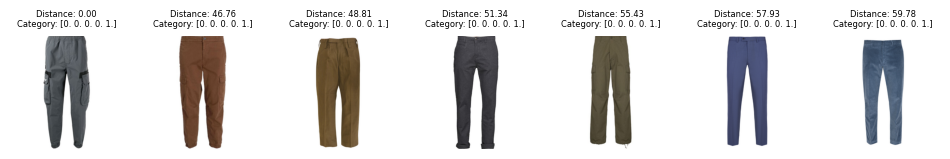

156/156 [==============================] - 13s 82ms/step


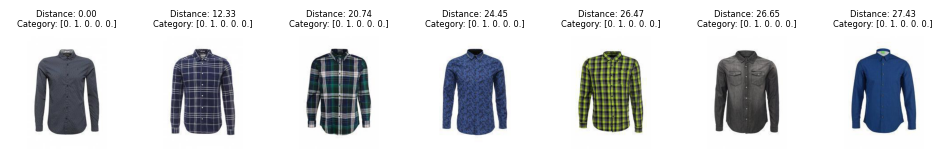

156/156 [==============================] - 13s 81ms/step


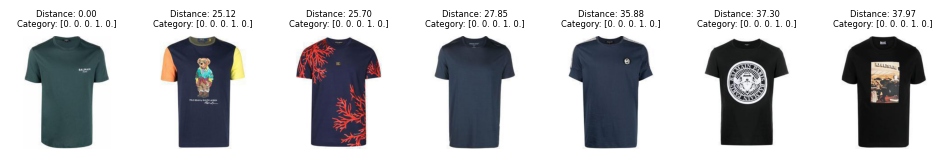

156/156 [==============================] - 12s 78ms/step


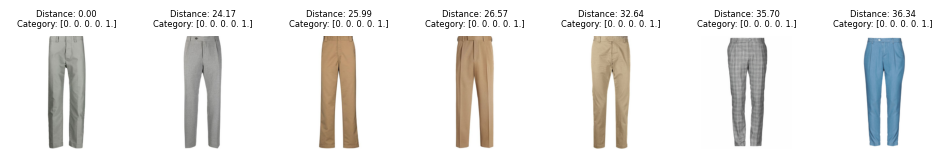

In [ ]:
show_neighbors(1)
show_neighbors(10)
show_neighbors(100)
show_neighbors(1000)